This is a starter notebook for the project, you'll have to import the libraries you'll need, you can find a list of the ones available in this workspace in the requirements.txt file in this workspace. 

## Step 1: Setting Up the Python Application

In [32]:
import os
import glob
import pandas as pd
import gradio as gr
import lancedb
import io
import base64
import re
import os
import glob
import base64
from IPython.display import HTML, Image, display, FileLink
import weasyprint
import threading

from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from sentence_transformers import SentenceTransformer
import torch
from diffusers import StableDiffusion3Pipeline


os.environ["OPENAI_API_KEY"] = "YOUR-API-KEYos.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"


### Some Handy Helper Functions

In [3]:
# Generic CSV file versioning helper functions.  
# These are used to save different versions of the home listings, user preferences, and the search results

class VersionedCSVHandler:
    def __init__(self, base_filename, csv_dir="./generated_csvs"):
        """
        Initialize the handler with a base filename.
        
        Args:
            base_filename (str): Base filename without extension (e.g., "user_preferences" or "search_results")
        """
        self.base_filename = base_filename
        self.csv_dir = csv_dir
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)
        self.file_pattern = f"{csv_dir}/{base_filename}_*.csv"
    
    def get_version_number(self, next_version=True):
        existing_files = glob.glob(self.file_pattern)
        if existing_files:
            # Extract numbers from filenames and find the maximum
            numbers = [int(f.split('_')[-1].split('.')[0]) for f in existing_files]
            return max(numbers) + 1 if next_version else max(numbers)
        return 1
    
    def save_df_to_csv(self, df):
        next_number = self.get_version_number()
        filename = f"{self.csv_dir}/{self.base_filename}_{next_number}.csv"
        
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return filename
      
    def save_content_to_csv(self, csv_content):
        next_number = self.get_version_number()
        filename = f"{self.csv_dir}/{self.base_filename}_{next_number}.csv"
        with open(filename, 'w') as file:
            file.write(csv_content)
        print(f"Data saved to {filename}")
        return filename
    
    def read_from_csv(self, version_number=None):
        try:
            if version_number is None:
                version_number = self.get_version_number(next_version=False)
            filename = f"{self.csv_dir}/{self.base_filename}_{version_number}.csv"
            df = pd.read_csv(filename)
            return df
        except FileNotFoundError:
            print(f"File {filename} not found. No data has been saved yet.")
            return None
        except Exception as e:
            print(f"Error reading data: {str(e)}")
            return None

In [4]:
# Initialize the CSV handlers for home listings, user preferences, and search results

listings_csv_version_handler = VersionedCSVHandler("home_listings")
pref_csv_version_handler = VersionedCSVHandler("user_preferences")
results_csv_version_handler = VersionedCSVHandler("search_results")

In [5]:
# Helper function to display dataframes with consistent styling

def display_df(df, columns_to_display=None):
    """
    Display search results with proper formatting
    
    Args:
        df (DataFrame): DataFrame containing search results
        columns_to_display (list, optional): List of columns to display. Defaults to key columns.
    """
    pd.set_option('display.max_colwidth', None)
    
    if columns_to_display is None:
        columns_to_display = df.columns.tolist()

    styled_df = df[columns_to_display].style.set_properties(**{
        'text-align': 'left',
        'white-space': 'normal',
        'width': 'auto'
    })
    
    display(styled_df)


## Step 2: Generating Real Estate Listings

In [6]:
# This is the home listings prompt template

homes_gen_template = """
Generate CSV formatted descriptions for home listings, with one CSV header row at the top row, and then precisely {home_rows} home rows, to make a total of precisely {total_rows} rows in the CSV.  
The home and neighborhood descriptions should be interesting but also realistic, and display a broad range of homes catering to different house purchaser tastes. Be creative and imaginative.  Commont on items that are a priority for families. 

Each home description should be between 15 and 22 words, and each neighborhood description between 20 and 27 words.

Carefully review the descriptions and any make changes needed to guarantee they are not similar to each other.  

As it is a CSV, ensure all prices and descriptions are between double quotes ("). 

Always include the following Columns in the CSV:
- Neighborhood
- Price
- Bedrooms number
- Bathrooms number
- House Size in square feet
- Detailed Description
- Detailed Neighborhood Description


EXAMPLE with precisely 2 home rows and 3 total rows in the CSV:
Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description
Sunnyvale,"650,000",4,3,"2,500","Discover your dream home in Sunnyvale! This stunning 4-bedroom, 3-bathroom residence features an expansive open floor plan, perfect for entertaining. The gourmet kitchen is equipped with stainless steel appliances and a large island, while the spacious living room boasts a cozy fireplace. Step outside to a beautifully landscaped backyard, ideal for summer barbecues and family gatherings. The master suite offers a private retreat with a luxurious en-suite bathroom and walk-in closet. Don't miss this opportunity to own a piece of paradise in Sunnyvale!","Sunnyvale is a vibrant community known for its excellent schools and family-friendly atmosphere. With numerous parks, playgrounds, and recreational facilities, there's always something to do. The neighborhood hosts seasonal farmers' markets and community events, fostering a strong sense of belonging. Enjoy easy access to shopping, dining, and major highways, making it a convenient location for commuters."
Maplewood,"1,200,000",5,4,"3,800","Welcome to this exquisite 5-bedroom, 4-bathroom estate in the prestigious Maplewood neighborhood. This luxurious home features high ceilings, elegant crown molding, and hardwood floors throughout. The chef's kitchen is a culinary delight, complete with granite countertops and a spacious pantry. The expansive master suite includes a spa-like bathroom and a private balcony overlooking the lush backyard. Enjoy movie nights in the dedicated home theater or host gatherings in the formal dining room. This home is a true masterpiece!","Maplewood is an upscale neighborhood characterized by tree-lined streets and beautifully manicured lawns. Residents enjoy a peaceful suburban lifestyle while being just minutes away from fine dining, boutique shopping, and cultural attractions. The community is known for its top-rated schools and active neighborhood associations, which organize events and activities throughout the year. With easy access to public transportation and major highways, Maplewood offers the perfect blend of luxury and convenience."
"""

prompt = ChatPromptTemplate.from_template(homes_gen_template)


In [7]:
# A relatively sophisticated LLM model was needed to generate the home listings

llm = init_chat_model("gpt-4o", model_provider="openai", temperature=0.0,max_tokens=12000)

In [8]:
# Place the LLM and the prompt into a LangChain chain

chain = prompt | llm

In [9]:
# This is the main function that generates the home listings
# Don't forget to set refresh_listings to True if you want to generate new listings

refresh_listings = False
# refresh_listings = True

df = listings_csv_version_handler.read_from_csv()

# If the df is None, the file doesn't exist
if refresh_listings or df is None:
    home_rows = 12
    total_rows = home_rows + 1

    print("Generating new home listings...")
    result = chain.invoke(
        {"home_rows": home_rows,
         "total_rows": total_rows}
    )
    print(result)
    content = result.content
    # The following check is necessary to deal with variability in the LLM output format
    if "```csv" in content and "```" in content:
        start = content.find("```csv") + 6  # Skip past "```csv"
        end = content.rfind("```")
        csv_content = content[start:end].strip()
    else:
        csv_content = content
    listings_csv_version_handler.save_content_to_csv(csv_content)
    print("New home listings generated and saved to CSV")
else:
    print("Proceeding using existing home listings previously saved to CSV")
    display_df(df)

Proceeding using existing home listings previously saved to CSV


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description
0,Greenfield,"450,000",3,2,"1,800",Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families.,"Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene."
1,Riverside,"850,000",4,3,"2,700",Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings.,"Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
2,Oakwood,"1,500,000",5,5,"4,200",Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain.,Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.
3,Lakeside,"600,000",3,2,"2,000",Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities.,Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.
4,Hillcrest,"950,000",4,4,"3,000",Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families.,Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.
5,Meadowbrook,"700,000",3,3,"2,300",Charming 3-bedroom cottage with a garden and sunroom. Perfect for nature lovers and gardeners.,Meadowbrook is a picturesque community with walking trails and community gardens. Families enjoy the friendly atmosphere and local markets.
6,Seaview,"2,200,000",6,6,"5,000",Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers.,Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.
7,Willow Creek,"500,000",3,2,"1,900",Cozy 3-bedroom home with a fireplace and large backyard. Great for families with children.,Willow Creek is a family-friendly neighborhood with excellent schools and parks. Residents enjoy community events and a strong sense of community.
8,Cedar Grove,"1,100,000",4,3,"3,200",Elegant 4-bedroom home with a library and formal dining room. Perfect for those who appreciate classic design.,Cedar Grove is known for its historic charm and cultural attractions. Families enjoy the educational opportunities and community involvement.
9,Sunset Valley,"750,000",3,2,"2,100",Contemporary 3-bedroom home with an open floor plan and large windows. Ideal for modern living.,Sunset Valley is a dynamic neighborhood with trendy shops and cafes. Families appreciate the excellent schools and community spirit.


## Step 3: Storing Listings in a Vector Database

In [10]:
# Load the CSV file
df = listings_csv_version_handler.read_from_csv()
df = df.fillna('')

# Convert numeric fields to proper numeric types
df['Price'] = df['Price'].str.replace(',', '').astype(int)
df['Bedrooms'] = df['Bedrooms'].astype(int)
df['Bathrooms'] = df['Bathrooms'].astype(float)
df['House Size (sqft)'] = df['House Size (sqft)'].str.replace(',', '').astype(int)


# Load the sentence embedding model
emb_model = SentenceTransformer("all-mpnet-base-v2")
if emb_model is None:
    raise ValueError("Failed to load the models. Please check the model names and paths.")


# Initialize LanceDB
os.makedirs("./lancedb_home_data", exist_ok=True)
db = lancedb.connect("./lancedb_home_data")


# Vector text for embedding
df['vector_text'] =  df["Description"] + "  " +df["Neighborhood Description"]
# ^^^^^^
# A combination of all parameters is not advisable due to truncation of long strings in embedding process
# When searching the db, it is better to combine description matches using vector embeddings with concrete filters on numeric parameters such as price and number of bedrooms
# This approach will be used later


# Create the embeddings
vector_text_list = df["vector_text"].tolist()
embeddings = emb_model.encode(vector_text_list, convert_to_numpy=True)
# Convert the embedding arrays to lists for JSON-friendly storage
df["vector"] = [list(vec) for vec in embeddings]


# Create the table directly from the DataFrame
table = db.create_table(
    "home_listings", 
    data=df,
    mode="overwrite"
)

# Create the vector index.  IVF_FLAT is the only feasible option for the small size dataset we test with
table.create_index(
    vector_column_name="vector",
    metric="Cosine",
    index_type="IVF_FLAT",  
)
print(f"Created table 'home_listings' with {len(df)} records")


Created table 'home_listings' with 12 records


In [11]:
# Quick search to ensure the embedding is adequate

query = "schools and parks"
query_embedding = emb_model.encode([query], convert_to_numpy=True)[0]


results = (
    table
    .search(query_embedding, query_type="vector")
    .limit(3)
    .to_pandas()
)


print("Search results:")
display_df(results[["Neighborhood", "vector_text"]])

Search results:


,Neighborhood,vector_text
0,Pine Ridge,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.
1,Riverside,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
2,Willow Creek,Cozy 3-bedroom home with a fireplace and large backyard. Great for families with children. Willow Creek is a family-friendly neighborhood with excellent schools and parks. Residents enjoy community events and a strong sense of community.


### Let's Add "Stable Diffusion"-Generated Images to Visually Represent Listings Content

In [12]:
# Let's add stable diffusion images of the generated listings to the table

# IMPORTANT:
# 1. This is an intensive process and may take more than 100GB of memory, depending on HW, and many minutes to run 
# 2. The images aren't always perfect, you may need to run 2-3 times and keep only the best image for each listing
# 3. The images are related to the actual listing content, so if you change the listings, you should regenerate
# 4. You can skip image generation and use existing images (a sample listings set and its images are in the repo) 


refresh_images = False
# refresh_images = True

if refresh_images or not os.path.exists("generated_images"):

    os.makedirs("generated_images", exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

    pipe = StableDiffusion3Pipeline.from_pretrained("tensorart/stable-diffusion-3.5-medium-turbo", torch_dtype=torch.float16,)

    print(f"Device: {device}")
    pipe = pipe.to(device)


    def generate_property_image(description, neighborhood, index):
        # The prompt is based on the property description and neighborhood name
        prompt = f"Photorealistic photo of a home, with natural outdoor daytime lighting, simulating professional real estate photography, not a drawing. Must be an outside photo of the whole, entire home. Must look like a photo. Description: {description}. Neighborhood: {neighborhood}."

        # Generate the image
        image = pipe(
            prompt=prompt,
            num_inference_steps=30, 
            guidance_scale=8.0, 
            height=256, 
            width=512
            ).images[0]

        # Save it
        image_path = f"./generated_images/property_{index}.jpg"
        image.save(image_path)

        # Convert it to base64 for db storage
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()

        return img_str, image_path
    

    tbl = db.open_table("home_listings")
    df = tbl.to_pandas()

    df['image_base64'] = None
    df['image_path'] = None

    # Generate images for each property
    for i, row in df.iterrows():
        print(f"Generating image for property {i+1}/{len(df)}: {row['Neighborhood']}")
        description = row['Description']
        neighborhood = row['Neighborhood']
        
        img_str, img_path = generate_property_image(description, neighborhood, i+1)
        
        df.at[i, 'image_base64'] = img_str
        df.at[i, 'image_path'] = img_path

    # Update the table with the new columns
    db.create_table("home_listings", data=df, mode="overwrite")  # Recreate with new data

    print("Images generated and added to the database!")

    # Function to display an image as a quick check
    def display_property_image(index):
        img_path = df.iloc[index]['image_path']
        display(Image(img_path))
        print(f"Property: {df.iloc[index]['Neighborhood']} - {df.iloc[index]['Description']}")

    # Example: Display the first property image
    display_property_image(0)

In [13]:
# Quick peak at the table data

tbl = db.open_table("home_listings")
tbl.to_pandas()

,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description,vector_text,vector
0,Greenfield,450000,3,2.0,1800,Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families.,"Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","[-0.04811635, -0.03358374, 0.0064837337, 0.037169084, -0.043963242, 0.02014311, -0.0058094915, 0.02623766, -0.03431652, 5.471295e-05, -0.041178018, -0.020973777, 0.016985992, 0.01958308, -0.015111541, 0.07185856, 0.041018475, 0.00365524, -0.056795467, 0.008429039, -0.010319874, 0.009899322, 0.023241844, 0.0086128, -0.029663457, 0.024247639, 0.0013405877, -0.012910159, 0.037226457, 0.048662808, -0.019548161, 0.051272128, -0.059941586, -0.0055373777, 2.21132e-06, 0.024366971, 0.029359683, -0.005148586, 0.04897356, -0.06553944, 0.019249154, 0.013055731, -0.01932325, 0.021452807, -0.018944072, 0.017188692, -0.006086958, 0.089235224, -0.05547025, -0.025053877, 0.00871688, -0.09119402, -0.114246346, 0.015791494, 0.028816855, 0.09841825, -0.014282966, -0.034624092, 0.031932965, -0.060183074, 0.00012147811, -0.022994855, -0.005081006, -0.011581461, 0.067288235, 0.0017707727, 0.005745843, 0.015693614, -0.027670791, 0.041795626, 0.0077946573, -0.016060187, -0.023545075, 0.0026587704, 0.004414961, -0.01772027, 0.018814629, 0.009580105, -0.019943465, -0.0057444945, -0.08663659, -0.03266256, 0.012042596, -0.029602183, 0.09375959, 0.0018028417, -0.0073298626, 0.09417264, -0.055661097, 0.009875161, 0.009891994, 0.055632737, -0.05195264, -0.0037993882, 0.030032901, -0.04131946, -0.03189035, 0.07795294, 0.045034878, 0.058469053, ...]"
1,Riverside,850000,4,3.0,2700,Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings.,"Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","[-0.07636355, -0.012919575, -0.018228773, 0.06620523, -0.041575596, 0.010153383, -0.03467045, -0.0055453684, -0.046187837, 0.015803503, -0.10441344, 0.031626903, 0.04454278, -0.035592187, -0.036933765, -0.018502368, 0.0058528758, -0.010764468, -0.0055621387, -0.025381217, -0.03443701, 0.003302618, 0.00043911848, -0.029347604, 0.028710075, -0.016503744, -0.027112626, -0.007029145, 0.015766602, 0.00403814, 0.014194989, 0.052452344, -0.0031485811, 0.0060307626, 1.950092e-06, 0.014081288, 0.007321755, 0.0056656837, 0.025867132, -0.03802763, 0.066687204, 0.023749104, -0.0013558558, -0.025322726, 0.0407602, -0.040604573, 0.008398828, 0.047973193, -0.04694527, -0.029082317, 0.009890653, -0.0594727, -0.08413448, -0.005921811, 0.061125953, 0.10140667, -0.010723675, 0.051988404, 0.072593704, 0.021141741, -0.03987164, -0.04296077, -0.0023224067, -0.027289001, 0.038279377, -0.009733913, -0.04905083, 0.0045696925, -0.003475645, 0.0047862036, -0.0008607038, -0.0067291567, -0.0076790024, 0.02980881, -0.030792013, -0.0017363948, 0.018717032, -0.006091616, 0.044697758, -0.016142428, -0.07012847, 0.000113167705, 0.004834806, 0.010791128, 0.09114848, -0.004854473, 0.026175044, 0.05734251, -0.06602217, 0.001998102, 0.037587807, 0.00398996, -0.025445689, 0.01868186, -0.0046180543, -0.0298726, -0.021349879, 0.049649116, 0.039998174, 0.052457985, ...]"
2,Oakwood,1500000,5,5.0,4200,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to enterta

## Step 4: Building the User Preference Interface



### Interactive user input

- A simple form for asking questions and receiving user inputs.   
- Every time a new form is filled, a new user_preferences_X.csv is dropped into the CSV folder
- The form is prepopulated with the most recent user_references CSV, and can be cancelled once there are enough user preference sets to test the system
- A set of sample user preference CSVs are in the github repo

In [14]:
# Set the questions
questions = {
    "How big do you want your house to be?  (format: 3-bedroom, 2-bathroom, 2500-sqft, large yard)": "",
    "What are the 3 most important things for you in choosing this property?": "",
    "Are there any specific amenities you would like?": "",
    "What type of neighborhood would you like (urban, suburban, rural, etc.)?": "",
    "Are there any neighborhood preferences (crime rate, school quality, shopping, etc.)?": "",
    "What is your budget? (number in dollars, for example: 500000)": "",
}

# Prepopulate the answers if there are existing preferences
existing_preferences = pref_csv_version_handler.read_from_csv()
if existing_preferences is not None:
    preferences_dict = dict(zip(existing_preferences['Question'], existing_preferences['Answer']))
    questions.update(preferences_dict)

print(questions)

def save_to_csv(questions_dict, base_filename="user_preferences"):
    df = pd.DataFrame({
        'Question': questions_dict.keys(),
        'Answer': questions_dict.values()
    })
    filename = pref_csv_version_handler.save_df_to_csv(df)

def update_answers(*args):
    answers = dict(zip(questions.keys(), args))
    questions.update(answers)
    save_to_csv(questions)
    # Schedule the demo to close after returning the UI update
    threading.Timer(0.5, lambda: demo.close()).start()
    return {input_container: gr.update(visible=False), output_json: answers}

def cancel_form():
    # Schedule the demo to close after returning the UI update
    threading.Timer(0.5, lambda: demo.close()).start()
    return {input_container: gr.update(visible=False), output_json: {"status": "Form cancelled"}}

with gr.Blocks() as demo:
    with gr.Column() as input_container:
        # Create textboxes with existing values
        inputs = [gr.Textbox(label=question, value=answer, lines=2) 
                 for question, answer in questions.items()]
        
        with gr.Row():
            submit_btn = gr.Button("Submit", variant="primary")
            cancel_btn = gr.Button("Cancel", variant="stop")
            
    output_json = gr.JSON(label="Your Preferences", visible=False)
    
    submit_btn.click(update_answers, inputs=inputs, outputs=[input_container, output_json])
    cancel_btn.click(cancel_form, inputs=None, outputs=[input_container, output_json])


try:
    demo.close()  # Close any existing instance
except:
    pass  # In case it wasn't running

demo.launch(prevent_thread_lock=True, show_error=True)

{'How big do you want your house to be?  (format: 3-bedroom, 2-bathroom, 2500-sqft, large yard)': '5-bedroom, 4-bathroom, 3500-sqft', 'What are the 3 most important things for you in choosing this property?': 'spacious, beautiful nature and views, luxurious', 'Are there any specific amenities you would like?': 'swimming pool or seaside', 'What type of neighborhood would you like (urban, suburban, rural, etc.)?': 'rural', 'Are there any neighborhood preferences (crime rate, school quality, shopping, etc.)?': 'quiet', 'What is your budget? (number in dollars, for example: 500000)': '2000000'}
* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Closing server running on port: 7860


## Step 5: Searching Based on Preferences



In [17]:

# Process user preferences into a meaningful search query
def extract_query_from_preferences(preferences):
    query_num_parts = {}
    
    # Extract budget
    for question, answer in preferences.items():
        if 'budget' in question.lower() or 'price' in question.lower():
            # Extract numbers from the budget answer
            budget_numbers = re.findall(r'\d[\d,]*', answer)
            if budget_numbers:
                query_num_parts["Price"] = int(budget_numbers[0].replace(',', ''))
        elif 'big' in question.lower() or 'size' in question.lower():
            bedroom_match = re.search(r'(\d+)[- ]bedroom', answer.lower())
            bathroom_match = re.search(r'(\d+)[- ]bathroom', answer.lower())
            sqft_match = re.search(r'([\d,]+)[- ]sq(?:uare)?[- ]?f(?:ee)?t', answer.lower())
            
            if bedroom_match:
                query_num_parts["Bedrooms"] = int(bedroom_match.group(1))
            if bathroom_match:
                query_num_parts["Bathrooms"] = float(bathroom_match.group(1))
            if sqft_match:
                query_num_parts["House Size (sqft)"] = int(sqft_match.group(1).replace(',', ''))
    
    return (query_num_parts, " ".join(preferences.values()))

def search_homes_by_preferences(preferences, variation_percentage=0.50, limit=3):
    query_numeric, query_text = extract_query_from_preferences(preferences)

    print("==========================")
    if query_numeric:
        print(f"User Query Numeric: {query_numeric} with allowed variation of {variation_percentage*100}%")

        # Build precise filter conditions for numeric parameters the user provided
        filter_conditions = []
        for col, value in query_numeric.items():
            if isinstance(value, int):
                lower_bound = int(value * (1 - variation_percentage))
                upper_bound = int(value * (1 + variation_percentage))
            else:
                lower_bound = value * (1 - variation_percentage)
                upper_bound = value * (1 + variation_percentage)
            print(f"  {col}: {lower_bound} to {upper_bound}")
            filter_conditions.append(f"`{col}` BETWEEN {lower_bound} AND {upper_bound}")
        filter_string = " AND ".join(filter_conditions)

    # Also encode the query answers semantically
    query_embedding = emb_model.encode([query_text], convert_to_numpy=True)[0]


    print(f"User Query Text: {query_text}")
    print("==========================")

    # Now we can search
    results = (
        table
        .search(query_embedding, query_type="vector")
        .where(filter_string, prefilter=True)
        .limit(limit)
        .to_pandas()
    )

    return results


## Step 6: Personalizing Listing Descriptions

In [19]:
# Augmenting the listing descriptions based on user preferences, carefully avoiding factual changes

prompt_template = """
    You are a real estate agent.
    You are given the buyer's preferences.
    Then, you are given a listing description.

    You are to augment the listing description to resonate with the buyer's preferences. 
    In your augmentation, you should subtly emphasize aspects of the property that align with what the buyer is looking for.
    
    However, you must not alter or generate any factual content that is not given to you in the LISTING DESCRIPTION. 
    Specifically, you must not mention the price, number of bedrooms, number of bathrooms, or square footage unless it is in the LISTING DESCRIPTION.

    BUYER PREFERENCES (NOT FACTUAL INFORMATION):
    {preferences}

    
    
    LISTING DESCRIPTION (FACTUAL INFORMATION):
    {listing_description}
    """

def augment_listing_descriptions(results_df, preferences, llm):
 
    prompt = ChatPromptTemplate.from_template(prompt_template)
    results_df['augmented_description'] = None
    results_df['user_prefs_version'] = pref_csv_version_handler.get_version_number(next_version=False)

    for index, row in results_df.iterrows():
        listing_description = row['vector_text']
        augmented_description = llm.invoke(prompt.format(preferences=preferences, listing_description=listing_description), temperature=0.0)
        results_df.at[index, 'augmented_description'] = augmented_description.content

    return results_df




## Step 7: Deliverables and Testing



In [22]:
# Helper function to generate HTML output for the search results

def generate_results_html(results, preferences):
    """Generate HTML output for the search results with property images"""
    # Create HTML table with images
    html_output = "<h2>HomeMatch Results</h2>"
    html_output += "<h3>Your Preferences:</h3>"
    html_output += "<p>" + " * ".join(preferences.values()) + "</p>"
    
    # Start HTML table
    html_output += """
    <table style="width:100%; border-collapse: collapse;">
      <tr style="background-color: #f2f2f2;">
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Property</th>
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Image</th>
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Description</th>
      </tr>
    """
    
    # Table rows for each property
    table_df = table.to_pandas()
    for idx, row in results.iterrows():
        # Format price with commas
        formatted_price = f"${row['Price']:,}"
        
        # Find the original index to locate the image
        original_idx = table_df.index[table_df['Neighborhood'] == row['Neighborhood']].tolist()
        image_html = ""
        
        if original_idx:
            image_path = f"./generated_images/property_{original_idx[0]+1}.jpg"
            if os.path.exists(image_path):
                with open(image_path, "rb") as img_file:
                    img_data = base64.b64encode(img_file.read()).decode()
                image_html = f'<img src="data:image/jpeg;base64,{img_data}" style="width:300px;">'
            else:
                image_html = "<p>No image available</p>"
        
        # Add row to table
        html_output += f"""
        <tr style="border: 1px solid #ddd;">
            <td style="padding: 12px; vertical-align: middle; border: 1px solid #ddd;">
                <strong>{row['Neighborhood']}</strong><br>
                <br>
                {formatted_price}<br>
                {row['Bedrooms']} bed / {row['Bathrooms']} bath<br>
                {row['House Size (sqft)']:,} sqft
            </td>
            <td style="padding: 12px; vertical-align: middle; border: 1px solid #ddd;">
                {image_html}
            </td>
            <td style="padding: 12px; text-align: justify; vertical-align: middle; border: 1px solid #ddd;">
                {row['augmented_description']}</p>
            </td>
        </tr>
        """
    
    # Close HTML table
    html_output += "</table>"
    
    return html_output


Showing results for preference set #1:
3-bedroom, 3-bathroom, 2500-sqft * quiet, spacious, beautiful * lake views or a pool * suburban * excellent schools * 700000
User Query Numeric: {'Bedrooms': 3, 'Bathrooms': 3.0, 'House Size (sqft)': 2500, 'Price': 700000} with allowed variation of 50.0%
  Bedrooms: 1 to 4
  Bathrooms: 1.5 to 4.5
  House Size (sqft): 1250 to 3750
  Price: 350000 to 1050000
User Query Text: 3-bedroom, 3-bathroom, 2500-sqft quiet, spacious, beautiful lake views or a pool suburban excellent schools 700000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Riverside,850000,4,3.000000,2700,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
1,Lakeside,600000,3,2.000000,2000,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.
2,Hillcrest,950000,4,4.000000,3000,Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families. Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.


Augmenting listing descriptions...


,Neighborhood,vector_text,augmented_description
0,Riverside,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","This spacious 4-bedroom home is perfect for those seeking a quiet and beautiful suburban lifestyle. With its inviting pool, it offers a serene escape for relaxation and leisure. The property is nestled in Riverside, a community known for its scenic river views and excellent schools, making it an ideal choice for families. The gourmet kitchen is perfect for those who love to entertain, and the vibrant downtown area provides a variety of shopping and dining options. Enjoy the tranquility of suburban living while being part of a community that values family-friendly events and outdoor activities."
1,Lakeside,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.,"This beautiful lakeside home offers the perfect blend of tranquility and space, ideal for those seeking a quiet and spacious retreat. With its serene lake views and private dock, you can indulge in water activities right from your backyard, making it a haven for relaxation and enjoyment. Nestled in a suburban setting, the home is part of the Lakeside community, known for its excellent schools and peaceful environment. Families will appreciate the local festivals and outdoor recreation opportunities, enhancing the beauty and charm of this desirable location."
2,Hillcrest,Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families. Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.,"Nestled in the vibrant Hillcrest neighborhood, this modern 4-bedroom home offers a perfect blend of tranquility and convenience. The property features a stunning rooftop terrace, providing a serene space to unwind and enjoy the beautiful surroundings. With smart home features, this residence is ideal for tech-savvy families seeking a spacious and quiet retreat. Hillcrest is renowned for its excellent schools, making it an ideal choice for families prioritizing education. The neighborhood's diverse dining options and cultural events add to its charm, while the nearby parks offer peaceful escapes for leisurely strolls or family outings. This home truly embodies the essence of suburban living, combining modern amenities with a beautiful setting."


Data saved to ./generated_csvs/search_results_8.csv


Property,Image,Description
"Riverside $850,000 4 bed / 3.0 bath 2,700 sqft",,"This spacious 4-bedroom home is perfect for those seeking a quiet and beautiful suburban lifestyle. With its inviting pool, it offers a serene escape for relaxation and leisure. The property is nestled in Riverside, a community known for its scenic river views and excellent schools, making it an ideal choice for families. The gourmet kitchen is perfect for those who love to entertain, and the vibrant downtown area provides a variety of shopping and dining options. Enjoy the tranquility of suburban living while being part of a community that values family-friendly events and outdoor activities."
"Lakeside $600,000 3 bed / 2.0 bath 2,000 sqft",,"This beautiful lakeside home offers the perfect blend of tranquility and space, ideal for those seeking a quiet and spacious retreat. With its serene lake views and private dock, you can indulge in water activities right from your backyard, making it a haven for relaxation and enjoyment. Nestled in a suburban setting, the home is part of the Lakeside community, known for its excellent schools and peaceful environment. Families will appreciate the local festivals and outdoor recreation opportunities, enhancing the beauty and charm of this desirable location."
"Hillcrest $950,000 4 bed / 4.0 bath 3,000 sqft",,"Nestled in the vibrant Hillcrest neighborhood, this modern 4-bedroom home offers a perfect blend of tranquility and convenience. The property features a stunning rooftop terrace, providing a serene space to unwind and enjoy the beautiful surroundings. With smart home features, this residence is ideal for tech-savvy families seeking a spacious and quiet retreat. Hillcrest is renowned for its excellent schools, making it an ideal choice for families prioritizing education. The neighborhood's diverse dining options and cultural events add to its charm, while the nearby parks offer peaceful escapes for leisurely strolls or family outings. This home truly embodies the essence of suburban living, combining modern amenities with a beautiful setting."

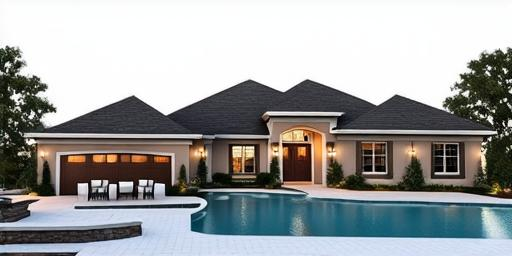
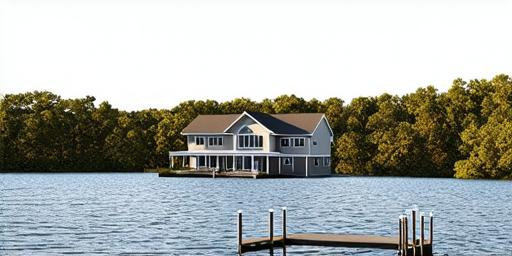
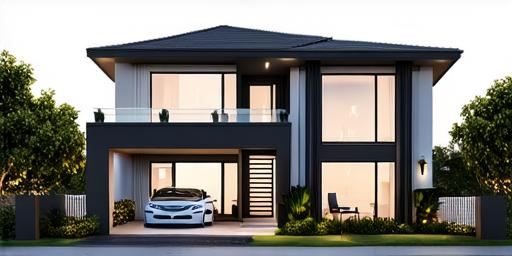

HTML saved to ./generated_pdfs/homematch_results_1.html for PDF generation in the next step
Showing results for preference set #2:
2-bedroom, 2-bathroom, 1500-sqft * first-time buyers, affordable, close to work * new kitchen * urban * low crime rate, shopping nearby * 400000
User Query Numeric: {'Bedrooms': 2, 'Bathrooms': 2.0, 'House Size (sqft)': 1500, 'Price': 400000} with allowed variation of 50.0%
  Bedrooms: 1 to 3
  Bathrooms: 1.0 to 3.0
  House Size (sqft): 750 to 2250
  Price: 200000 to 600000
User Query Text: 2-bedroom, 2-bathroom, 1500-sqft first-time buyers, affordable, close to work new kitchen urban low crime rate, shopping nearby 400000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Greenfield,450000,3,2.000000,1800,"Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene."
1,Brookside,550000,3,2.000000,2000,Charming 3-bedroom home with a wraparound porch and cozy interior. Ideal for those seeking comfort. Brookside is a friendly neighborhood with parks and local shops. Families enjoy the community events and welcoming atmosphere.
2,Lakeside,600000,3,2.000000,2000,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.


Augmenting listing descriptions...


,Neighborhood,vector_text,augmented_description
0,Greenfield,"Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","Charming 3-bedroom home with a cozy fireplace and modern kitchen, ideal for first-time buyers seeking an affordable and comfortable living space. The modern kitchen is perfect for those who appreciate updated amenities. Nestled in the urban setting of Greenfield, this home offers the convenience of nearby shopping and a vibrant arts scene, making it an excellent choice for those who want to be close to work and enjoy the perks of city living. The community is known for its low crime rate and welcoming atmosphere, with excellent schools and parks, providing a safe and enjoyable environment for all. Enjoy the local cafes and immerse yourself in the lively neighborhood events that make Greenfield a truly special place to call home."
1,Brookside,Charming 3-bedroom home with a wraparound porch and cozy interior. Ideal for those seeking comfort. Brookside is a friendly neighborhood with parks and local shops. Families enjoy the community events and welcoming atmosphere.,"Charming 3-bedroom home with a wraparound porch and cozy interior, perfect for first-time buyers looking for a comfortable and inviting space. Nestled in the urban setting of Brookside, this home offers the convenience of local shops just a short stroll away, making it ideal for those who value easy access to shopping. The friendly neighborhood is known for its low crime rate, providing peace of mind for residents. Enjoy the vibrant community events and welcoming atmosphere that make Brookside a delightful place to call home."
2,Lakeside,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.,"Beautiful lakeside home with a private dock, perfect for enjoying serene views and water activities. This property is ideal for first-time buyers seeking a peaceful yet urban lifestyle. Located in the tranquil Lakeside community, you'll find excellent schools and a low crime rate, ensuring a safe and welcoming environment. The area is known for its vibrant local festivals and convenient shopping options nearby, making it a great choice for those who value both relaxation and accessibility. While the home features three bedrooms, its spacious layout offers flexibility for those looking to create a cozy, affordable living space."


Data saved to ./generated_csvs/search_results_9.csv


Property,Image,Description
"Greenfield $450,000 3 bed / 2.0 bath 1,800 sqft",,"Charming 3-bedroom home with a cozy fireplace and modern kitchen, ideal for first-time buyers seeking an affordable and comfortable living space. The modern kitchen is perfect for those who appreciate updated amenities. Nestled in the urban setting of Greenfield, this home offers the convenience of nearby shopping and a vibrant arts scene, making it an excellent choice for those who want to be close to work and enjoy the perks of city living. The community is known for its low crime rate and welcoming atmosphere, with excellent schools and parks, providing a safe and enjoyable environment for all. Enjoy the local cafes and immerse yourself in the lively neighborhood events that make Greenfield a truly special place to call home."
"Brookside $550,000 3 bed / 2.0 bath 2,000 sqft",,"Charming 3-bedroom home with a wraparound porch and cozy interior, perfect for first-time buyers looking for a comfortable and inviting space. Nestled in the urban setting of Brookside, this home offers the convenience of local shops just a short stroll away, making it ideal for those who value easy access to shopping. The friendly neighborhood is known for its low crime rate, providing peace of mind for residents. Enjoy the vibrant community events and welcoming atmosphere that make Brookside a delightful place to call home."
"Lakeside $600,000 3 bed / 2.0 bath 2,000 sqft",,"Beautiful lakeside home with a private dock, perfect for enjoying serene views and water activities. This property is ideal for first-time buyers seeking a peaceful yet urban lifestyle. Located in the tranquil Lakeside community, you'll find excellent schools and a low crime rate, ensuring a safe and welcoming environment. The area is known for its vibrant local festivals and convenient shopping options nearby, making it a great choice for those who value both relaxation and accessibility. While the home features three bedrooms, its spacious layout offers flexibility for those looking to create a cozy, affordable living space."

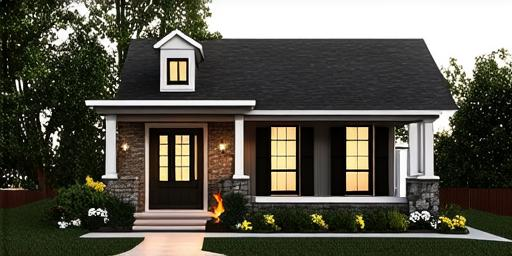
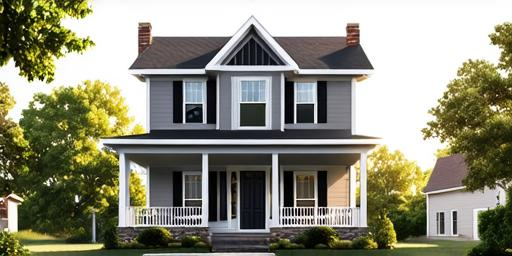
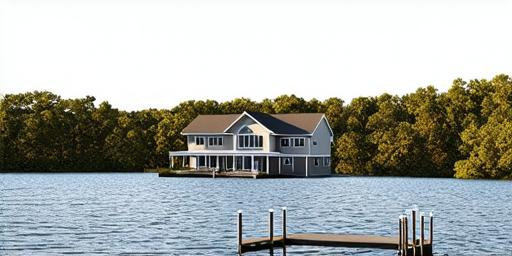

HTML saved to ./generated_pdfs/homematch_results_2.html for PDF generation in the next step
Showing results for preference set #3:
5-bedroom, 4-bathroom, 3500-sqft * spacious, beautiful nature and views, luxurious * swimming pool or seaside * rural * quiet * 2000000
User Query Numeric: {'Bedrooms': 5, 'Bathrooms': 4.0, 'House Size (sqft)': 3500, 'Price': 2000000} with allowed variation of 50.0%
  Bedrooms: 2 to 7
  Bathrooms: 2.0 to 6.0
  House Size (sqft): 1750 to 5250
  Price: 1000000 to 3000000
User Query Text: 5-bedroom, 4-bathroom, 3500-sqft spacious, beautiful nature and views, luxurious swimming pool or seaside rural quiet 2000000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Seaview,2200000,6,6.000000,5000,Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers. Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.
1,Oakwood,1500000,5,5.000000,4200,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain. Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.
2,Pine Ridge,1300000,5,4.000000,3600,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.


Augmenting listing descriptions...


,Neighborhood,vector_text,augmented_description
0,Seaview,Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers. Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.,"This stunning 6-bedroom beachfront property offers an unparalleled living experience, perfectly aligning with your desire for a spacious and luxurious home. Nestled in the prestigious coastal neighborhood of Seaview, this residence provides breathtaking panoramic ocean views, ensuring you are always surrounded by the beauty of nature. The exclusive lifestyle of Seaview is ideal for those seeking a quiet, rural setting, where you can enjoy the tranquility of private beaches and the gentle sound of the waves. This dream home is perfect for beach lovers who appreciate the finer things in life, offering a serene escape with ample opportunities for ocean activities right at your doorstep."
1,Oakwood,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain. Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.,"Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain, this property offers a truly spacious environment, ideal for creating memorable experiences with family and friends. Nestled in the exclusive Oakwood neighborhood, you'll find yourself surrounded by beautiful nature and stunning views, providing a serene and picturesque setting. The tree-lined streets enhance the rural charm, offering a quiet and peaceful atmosphere. With luxury amenities and a focus on privacy, this estate is a perfect match for those seeking a luxurious lifestyle. Enjoy the convenience of being close to fine dining while relishing the tranquility of your surroundings."
2,Pine Ridge,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.,"This spacious 5-bedroom home is a perfect match for those seeking a luxurious and serene lifestyle. Nestled in the tranquil Pine Ridge neighborhood, this property offers a peaceful rural setting, ideal for those who value quiet and privacy. The home features a beautiful swimming pool, providing a refreshing escape and a perfect spot for relaxation or entertaining guests. The outdoor kitchen enhances the luxurious feel, making it an excellent choice for hosting memorable summer gatherings. With its proximity to beautiful nature and stunning views, this home offers a harmonious blend of comfort and elegance. Pine Ridge is renowned for its top-rated schools and vibrant community, ensuring a fulfilling and active lifestyle for families."


Data saved to ./generated_csvs/search_results_10.csv


Property,Image,Description
"Seaview $2,200,000 6 bed / 6.0 bath 5,000 sqft",,"This stunning 6-bedroom beachfront property offers an unparalleled living experience, perfectly aligning with your desire for a spacious and luxurious home. Nestled in the prestigious coastal neighborhood of Seaview, this residence provides breathtaking panoramic ocean views, ensuring you are always surrounded by the beauty of nature. The exclusive lifestyle of Seaview is ideal for those seeking a quiet, rural setting, where you can enjoy the tranquility of private beaches and the gentle sound of the waves. This dream home is perfect for beach lovers who appreciate the finer things in life, offering a serene escape with ample opportunities for ocean activities right at your doorstep."
"Oakwood $1,500,000 5 bed / 5.0 bath 4,200 sqft",,"Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain, this property offers a truly spacious environment, ideal for creating memorable experiences with family and friends. Nestled in the exclusive Oakwood neighborhood, you'll find yourself surrounded by beautiful nature and stunning views, providing a serene and picturesque setting. The tree-lined streets enhance the rural charm, offering a quiet and peaceful atmosphere. With luxury amenities and a focus on privacy, this estate is a perfect match for those seeking a luxurious lifestyle. Enjoy the convenience of being close to fine dining while relishing the tranquility of your surroundings."
"Pine Ridge $1,300,000 5 bed / 4.0 bath 3,600 sqft",,"This spacious 5-bedroom home is a perfect match for those seeking a luxurious and serene lifestyle. Nestled in the tranquil Pine Ridge neighborhood, this property offers a peaceful rural setting, ideal for those who value quiet and privacy. The home features a beautiful swimming pool, providing a refreshing escape and a perfect spot for relaxation or entertaining guests. The outdoor kitchen enhances the luxurious feel, making it an excellent choice for hosting memorable summer gatherings. With its proximity to beautiful nature and stunning views, this home offers a harmonious blend of comfort and elegance. Pine Ridge is renowned for its top-rated schools and vibrant community, ensuring a fulfilling and active lifestyle for families."

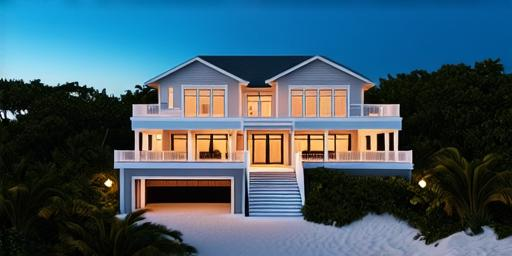
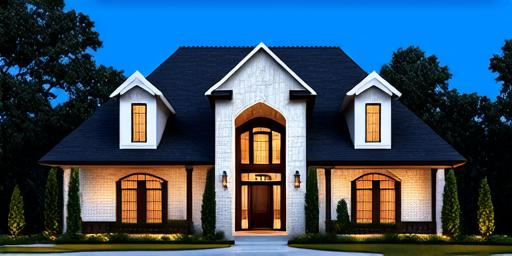
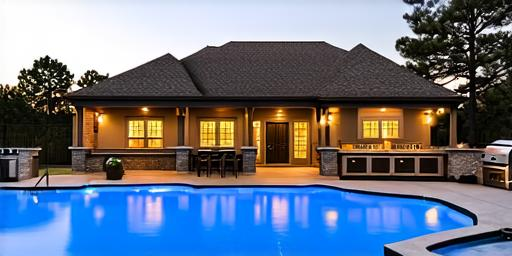

HTML saved to ./generated_pdfs/homematch_results_3.html for PDF generation in the next step


In [24]:
# Conduct the searches using the saved user preferences, one set per available preferences CSV file

preferences_df = pref_csv_version_handler.read_from_csv()
if preferences_df is None:
    print(f"No preferences found. Please fill out the User Preferences form to generate preference CSV files.")


for i in range(pref_csv_version_handler.get_version_number(next_version=False)):
    prefs_version = i+1
    preferences_df = pref_csv_version_handler.read_from_csv(version_number=prefs_version)
    preferences = dict(zip(preferences_df['Question'], preferences_df['Answer']))
    
    print(f"Showing results for preference set #{prefs_version}:")
    print(" * ".join(preferences.values()))

    results = search_homes_by_preferences(preferences)
    
    print("Search results:")
    display_df(results[["Neighborhood", "Price", "Bedrooms", "Bathrooms", "House Size (sqft)", "vector_text"]])

    print("Augmenting listing descriptions...")
    results = augment_listing_descriptions(results, preferences, llm)    
    display_df(results[['Neighborhood', 'vector_text', 'augmented_description']])
    results_csv_version_handler.save_df_to_csv(results)


    html_output = generate_results_html(results, preferences)

    display(HTML(html_output))
    html_filename = f"./generated_pdfs/homematch_results_{prefs_version}.html"
    with open(html_filename, "w") as f:
        f.write(html_output)
    print(f"HTML saved to {html_filename} for PDF generation in the next step")


In [36]:
# Combine all the HMTL into a single output PDF file

html_files = sorted(glob.glob('./generated_pdfs/homematch_results_*.html'))
if not html_files:
    print("No HTML files found to convert to PDF")
else:
    print(f"Found {len(html_files)} HTML files to convert")
    
    # Create directory for PDFs
    os.makedirs('./generated_pdfs', exist_ok=True)
    
    # Custom CSS with sans-serif font and fixed table layout
    custom_css = """
    <style>
        body, table, p, h1, h2, h3 {
            font-family: Arial, Helvetica, sans-serif;
            font-size: 10px;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            table-layout: fixed;
        }
        th, td {
            display: table-cell;
            padding: 12px;
            text-align: left;
            border: 1px solid #ddd;
        }
        th {
            background-color: #f2f2f2;
        }
        img {
            max-width: 100%;
            width: auto;
            height: auto;
        }
    </style>
    """

    
    # Define a colgroup to directly control column widths
    colgroup_html = """
    <colgroup>
      <col style="width:15%;">
      <col style="width:20%;">
      <col style="width:65%;">
    </colgroup>
    """
    
    # Helper function to insert the colgroup right after the opening <table> tag
    def insert_colgroup(html_content):
        # If a colgroup already exists, do nothing.
        if re.search(r'<colgroup>', html_content, re.IGNORECASE):
            return html_content
        # Insert the colgroup immediately after the opening <table> tag.
        return re.sub(r'(<table[^>]*>)', r'\1' + colgroup_html, html_content, count=1, flags=re.IGNORECASE)
    
    # Process each HTML file individually and generate its PDF
    for html_file in html_files:
        base_name = os.path.basename(html_file)
        pdf_name = os.path.splitext(base_name)[0] + ".pdf"
        pdf_path = os.path.join('./generated_pdfs', pdf_name)
        
        try:
            print(f"Converting {html_file} to {pdf_path}")
            with open(html_file, 'r') as f:
                html_content = f.read()
            
            # Modified insertion: insert the CSS into <head> if it exists; otherwise, create a <head>
            if re.search(r'<head[^>]*>', html_content, re.IGNORECASE):
                html_content = re.sub(r'(<head[^>]*>)', r'\1' + custom_css, html_content, flags=re.IGNORECASE)
            else:
                html_content = '<head>' + custom_css + '</head>' + html_content
            
            # Insert the colgroup to enforce column widths
            html_content = insert_colgroup(html_content)
            
            # Generate PDF from the processed HTML content
            pdf = weasyprint.HTML(string=html_content).write_pdf()
            with open(pdf_path, 'wb') as f:
                f.write(pdf)
            print(f"Successfully created {pdf_path}")
        except Exception as e:
            print(f"Error creating PDF from {html_file}: {str(e)}")
    
    # Combine all HTML files into one PDF
    try:
        combined_html = custom_css
        for html_file in html_files:
            with open(html_file, 'r') as f:
                content = f.read()
            # Insert custom CSS into the <head> if not already present
            content = re.sub(r'(<head[^>]*>)', r'\1' + custom_css, content, flags=re.IGNORECASE)
            # Insert colgroup to enforce column widths
            content = insert_colgroup(content)
            combined_html += content
        combined_pdf_path = './generated_pdfs/homematch_all_results.pdf'
        combined_pdf = weasyprint.HTML(string=combined_html).write_pdf()
        with open(combined_pdf_path, 'wb') as f:
            f.write(combined_pdf)
        print(f"Successfully created combined PDF with enforced column widths: {combined_pdf_path}")

        # Display the link to the combined PDF
        print(f"\n\n\n=================\n\n\nLISTINGS PDF IS AVAILABLE NOW: \n\n\n{combined_pdf_path}\n\n\nOr try the display FileLink below:\n")
        display(FileLink(combined_pdf_path))
    except Exception as e:
        print(f"Error creating combined PDF: {str(e)}")

Found 3 HTML files to convert
Converting ./generated_pdfs/homematch_results_1.html to ./generated_pdfs/homematch_results_1.pdf
Successfully created ./generated_pdfs/homematch_results_1.pdf
Converting ./generated_pdfs/homematch_results_2.html to ./generated_pdfs/homematch_results_2.pdf
Successfully created ./generated_pdfs/homematch_results_2.pdf
Converting ./generated_pdfs/homematch_results_3.html to ./generated_pdfs/homematch_results_3.pdf
Successfully created ./generated_pdfs/homematch_results_3.pdf
Successfully created combined PDF with enforced column widths: ./generated_pdfs/homematch_all_results.pdf





LISTINGS PDF IS AVAILABLE NOW: 


./generated_pdfs/homematch_all_results.pdf


Or try the display FileLink below:



/Users/Hani_1/Desktop/Udacity/Study Projects/cd13303-genai/genai-realtor/generated_pdfs/homematch_all_results.pdf